In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
from lstm_architecture import one_hot, run_with_config

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# network config

In [2]:
class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    """

    def __init__(self, X_train, X_test):
        # Data shaping
        self.train_count = len(X_train)  # 160000 training series
        self.test_data_count = len(X_test)  # 40000 testing series
        self.n_steps = len(X_train[0])  # 14 time_steps per series
        self.n_classes = 14  # Final output classes

        # Training
        self.learning_rate = 0.0001
        self.lambda_loss_amount = 0.005
        self.training_epochs = 1000
        self.batch_size = 128
        self.clip_gradients = 15.0
        self.gradient_noise_scale = None
        # Dropout is added on inputs and after each stacked layers (but not
        # between residual layers).
        self.keep_prob_for_dropout = 0.85  # **(1/3.0)

        # Linear+relu structure
        self.bias_mean = 0.3
        # I would recommend between 0.1 and 1.0 or to change and use a xavier
        # initializer
        self.weights_stddev = 0.2

        ########
        # NOTE: I think that if any of the below parameters are changed,
        # the best is to readjust every parameters in the "Training" section
        # above to properly compare the architectures only once optimised.
        ########

        # LSTM structure
        # Features count is of 9: three 3D sensors features over time
        self.n_inputs = len(X_train[0][0])
        self.n_hidden = 128  # nb of neurons inside the neural network
        # Use bidir in every LSTM cell, or not:
        self.use_bidirectionnal_cells = False

        # High-level deep architecture
        self.also_add_dropout_between_stacked_cells = False 

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14)
test_x = test_x.reshape(len(test_x), 10, 14)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14), (80000, 14), (20000, 10, 14), (20000, 14))


# train and test

In [5]:
n_layers_in_highway = 0
n_stacked_layers = 3
trial_name = "{}x{}".format(n_layers_in_highway, n_stacked_layers)

for learning_rate in [0.0001]:  # [0.01, 0.007, 0.001, 0.0007, 0.0001]:
    for lambda_loss_amount in [0.005]:
        for clip_gradients in [15.0]:
            print "learning_rate: {}".format(learning_rate)
            print "lambda_loss_amount: {}".format(lambda_loss_amount)
            print ""

            class EditedConfig(Config):
                def __init__(self, X, Y):
                    super(EditedConfig, self).__init__(X, Y)

                    # Edit only some parameters:
                    self.learning_rate = learning_rate
                    self.lambda_loss_amount = lambda_loss_amount
                    self.clip_gradients = clip_gradients
                    # Architecture params:
                    self.n_layers_in_highway = n_layers_in_highway
                    self.n_stacked_layers = n_stacked_layers

            # # Useful catch upon looping (e.g.: not enough memory)
            # try:
            #     accuracy_out, best_accuracy = run_with_config(EditedConfig)
            # except:
            #     accuracy_out, best_accuracy = -1, -1
            accuracy_out, best_accuracy, f1_score_out, best_f1_score, recall_out, precision_out = (
                run_with_config(EditedConfig, train_x, train_y, test_x, test_y)
            )
            print (accuracy_out, best_accuracy, f1_score_out, best_f1_score, recall_out, precision_out)

            with open('result/{}_result_.txt'.format(trial_name), 'a') as f:
                f.write(str(learning_rate) + ' \t' + str(lambda_loss_amount) + \
                        ' \t' + str(clip_gradients) + ' \t' + str(accuracy_out) + \
                        ' \t' + str(best_accuracy) + ' \t' + str(f1_score_out) + \
                        ' \t' + str(best_f1_score) + ' \t' + str(recall_out) + \
                        ' \t' + str(precision_out) + '\n\n')

            print "______________________________________"
        print ""
print "Done."

learning_rate: 0.0001
lambda_loss_amount: 0.005

Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
((20000, 10, 14), (20000, 14), 0.21035463, 0.12504394)
the dataset is therefore properly normalised, as expected.
(10, ?, 14)
(?, 14)
(10, '(?, 14)')

Creating hidden #1:
(10, '(?, 128)')

Creating hidden #2:
(10, '(?, 128)')

Creating hidden #3:
(10, '(?, 128)')

Unregularised variables:
LSTM_network/layer_1/relu_fc_biases_noreg:0
LSTM_network/layer_2/relu_fc_biases_noreg:0
LSTM_network/layer_3/relu_fc_biases_noreg:0
LSTM_network/relu_fc_biases_noreg:0


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


iter: 0, train loss: 4.66548252106, train accuracy: 0.796875, train F1-score: 0.748816403702, test loss: 4.33021402359, test accuracy: 0.908699989319, test F1-score: 0.887542623593test recall: 0.9087, test precision: 0.877783904187
iter: 1, train loss: 3.62164831161, train accuracy: 0.859375, train F1-score: 0.86556137931, test loss: 5.10583305359, test accuracy: 0.182150006294, test F1-score: 0.154166800513test recall: 0.18215, test precision: 0.170249683269
iter: 2, train loss: 3.12679958344, train accuracy: 0.84375, train F1-score: 0.811652215711, test loss: 6.45663070679, test accuracy: 0.169499993324, test F1-score: 0.143037695096test recall: 0.1695, test precision: 0.138451000925
iter: 3, train loss: 2.74250888824, train accuracy: 0.8828125, train F1-score: 0.841206682786, test loss: 6.92186594009, test accuracy: 0.166350007057, test F1-score: 0.137664226878test recall: 0.16635, test precision: 0.132173546076
iter: 4, train loss: 2.4977221489, train accuracy: 0.875, train F1-scor

iter: 36, train loss: 0.747598409653, train accuracy: 0.8671875, train F1-score: 0.918260378834, test loss: 5.35779523849, test accuracy: 0.165150001645, test F1-score: 0.140348124002test recall: 0.16515, test precision: 0.149129524509


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


iter: 37, train loss: 0.740659952164, train accuracy: 0.8828125, train F1-score: 0.929767972916, test loss: 5.3674659729, test accuracy: 0.16249999404, test F1-score: 0.141265433196test recall: 0.1625, test precision: 0.148894910211
iter: 38, train loss: 0.804955601692, train accuracy: 0.859375, train F1-score: 0.90047083398, test loss: 5.19854593277, test accuracy: 0.164149999619, test F1-score: 0.138874020518test recall: 0.16415, test precision: 0.133371174646
iter: 39, train loss: 0.736160874367, train accuracy: 0.875, train F1-score: 0.9142686213, test loss: 5.37085676193, test accuracy: 0.166150003672, test F1-score: 0.141291345018test recall: 0.16615, test precision: 0.152918167334
iter: 40, train loss: 0.739000558853, train accuracy: 0.8671875, train F1-score: 0.92279599316, test loss: 5.33345270157, test accuracy: 0.16099999845, test F1-score: 0.138541026501test recall: 0.161, test precision: 0.133145687196
iter: 41, train loss: 0.73175829649, train accuracy: 0.8671875, train F

iter: 73, train loss: 0.59680891037, train accuracy: 0.9140625, train F1-score: 0.952632913226, test loss: 5.18738174438, test accuracy: 0.165999993682, test F1-score: 0.141555233375test recall: 0.166, test precision: 0.14514397922
iter: 74, train loss: 0.561056792736, train accuracy: 0.921875, train F1-score: 0.940972222222, test loss: 5.31206083298, test accuracy: 0.16629999876, test F1-score: 0.140921277705test recall: 0.1663, test precision: 0.136496216362
iter: 75, train loss: 0.582123339176, train accuracy: 0.921875, train F1-score: 0.899712747452, test loss: 5.38913154602, test accuracy: 0.162699997425, test F1-score: 0.13758127469test recall: 0.1627, test precision: 0.131919408695
iter: 76, train loss: 0.589898884296, train accuracy: 0.9296875, train F1-score: 0.943340816245, test loss: 5.44695711136, test accuracy: 0.160549998283, test F1-score: 0.137405126713test recall: 0.16055, test precision: 0.131760593464
iter: 77, train loss: 0.566089034081, train accuracy: 0.9296875, t

iter: 108, train loss: 0.510886192322, train accuracy: 0.9296875, train F1-score: 0.921305898872, test loss: 5.19733667374, test accuracy: 0.165849998593, test F1-score: 0.138707920065test recall: 0.16585, test precision: 0.133292945719
iter: 109, train loss: 0.551590740681, train accuracy: 0.9296875, train F1-score: 0.907387827962, test loss: 5.54737043381, test accuracy: 0.161449998617, test F1-score: 0.137470642657test recall: 0.16145, test precision: 0.132093757017
iter: 110, train loss: 0.557662129402, train accuracy: 0.9140625, train F1-score: 0.915126596942, test loss: 5.4428191185, test accuracy: 0.161050006747, test F1-score: 0.137110029611test recall: 0.16105, test precision: 0.131552642781
iter: 111, train loss: 0.539615154266, train accuracy: 0.90625, train F1-score: 0.910304960052, test loss: 5.5310549736, test accuracy: 0.168999999762, test F1-score: 0.140498497048test recall: 0.169, test precision: 0.152122224484
iter: 112, train loss: 0.529980361462, train accuracy: 0.9

iter: 143, train loss: 0.500155806541, train accuracy: 0.921875, train F1-score: 0.92355621966, test loss: 5.54999160767, test accuracy: 0.165049999952, test F1-score: 0.140996755836test recall: 0.16505, test precision: 0.152021258954
iter: 144, train loss: 0.531447649002, train accuracy: 0.9140625, train F1-score: 0.945915629509, test loss: 5.43670940399, test accuracy: 0.166099995375, test F1-score: 0.13888313851test recall: 0.1661, test precision: 0.133317365988
iter: 145, train loss: 0.486133813858, train accuracy: 0.921875, train F1-score: 0.94402320614, test loss: 5.45548200607, test accuracy: 0.161200001836, test F1-score: 0.137126829386test recall: 0.1612, test precision: 0.131653187025
iter: 146, train loss: 0.690962195396, train accuracy: 0.890625, train F1-score: 0.97281283227, test loss: 5.49928236008, test accuracy: 0.162850007415, test F1-score: 0.140631528714test recall: 0.16285, test precision: 0.13629582565
iter: 147, train loss: 0.517271876335, train accuracy: 0.91406

iter: 178, train loss: 0.469244599342, train accuracy: 0.921875, train F1-score: 0.925091911765, test loss: 5.31395244598, test accuracy: 0.165299996734, test F1-score: 0.139128979587test recall: 0.1653, test precision: 0.133615608917
iter: 179, train loss: 0.476650834084, train accuracy: 0.9296875, train F1-score: 0.921609134205, test loss: 5.58249139786, test accuracy: 0.16455000639, test F1-score: 0.141580518848test recall: 0.16455, test precision: 0.152482588599
iter: 180, train loss: 0.493545293808, train accuracy: 0.90625, train F1-score: 0.951909722222, test loss: 5.56931686401, test accuracy: 0.167250007391, test F1-score: 0.14035824317test recall: 0.16725, test precision: 0.15787293213
iter: 181, train loss: 0.511274576187, train accuracy: 0.9140625, train F1-score: 0.936416320825, test loss: 5.58752298355, test accuracy: 0.163800001144, test F1-score: 0.140427790327test recall: 0.1638, test precision: 0.151222546793
iter: 182, train loss: 0.603120088577, train accuracy: 0.875

iter: 213, train loss: 0.542605042458, train accuracy: 0.9140625, train F1-score: 0.904198775289, test loss: 5.22377967834, test accuracy: 0.168050006032, test F1-score: 0.142330470917test recall: 0.16805, test precision: 0.153672552073
iter: 214, train loss: 0.468422591686, train accuracy: 0.9140625, train F1-score: 0.95239186217, test loss: 5.5084733963, test accuracy: 0.165000006557, test F1-score: 0.141483462174test recall: 0.165, test precision: 0.148330081321
iter: 215, train loss: 0.502852618694, train accuracy: 0.921875, train F1-score: 0.93830296048, test loss: 5.53106832504, test accuracy: 0.166549995542, test F1-score: 0.141161975837test recall: 0.16655, test precision: 0.148902903485
iter: 216, train loss: 0.520394921303, train accuracy: 0.921875, train F1-score: 0.912199173851, test loss: 5.26407718658, test accuracy: 0.162599995732, test F1-score: 0.14003116089test recall: 0.1626, test precision: 0.150895338224
iter: 217, train loss: 0.48082369566, train accuracy: 0.92187

iter: 248, train loss: 0.545586466789, train accuracy: 0.90625, train F1-score: 0.781727421427, test loss: 5.58449983597, test accuracy: 0.16590000689, test F1-score: 0.13747030216test recall: 0.1659, test precision: 0.131544045444
iter: 249, train loss: 0.495825797319, train accuracy: 0.9296875, train F1-score: 0.936197916667, test loss: 5.57883310318, test accuracy: 0.162300005555, test F1-score: 0.139927578735test recall: 0.1623, test precision: 0.151474972168
iter: 250, train loss: 0.48130017519, train accuracy: 0.9296875, train F1-score: 0.937044726107, test loss: 5.53861141205, test accuracy: 0.167899996042, test F1-score: 0.138635939605test recall: 0.1679, test precision: 0.137764811492
iter: 251, train loss: 0.561173737049, train accuracy: 0.9140625, train F1-score: 0.933163027041, test loss: 5.5636177063, test accuracy: 0.166950002313, test F1-score: 0.137957930888test recall: 0.16695, test precision: 0.137427887438
iter: 252, train loss: 0.609848976135, train accuracy: 0.9140

iter: 283, train loss: 0.461300909519, train accuracy: 0.921875, train F1-score: 0.952660214389, test loss: 5.54709339142, test accuracy: 0.167850002646, test F1-score: 0.142193969704test recall: 0.16785, test precision: 0.148657290395
iter: 284, train loss: 0.538127243519, train accuracy: 0.890625, train F1-score: 0.926368464052, test loss: 5.60364246368, test accuracy: 0.164749994874, test F1-score: 0.140133989268test recall: 0.16475, test precision: 0.151071506142
iter: 285, train loss: 0.475039333105, train accuracy: 0.90625, train F1-score: 0.927004255129, test loss: 5.56945610046, test accuracy: 0.167150005698, test F1-score: 0.141146889767test recall: 0.16715, test precision: 0.152250325123
iter: 286, train loss: 0.52175951004, train accuracy: 0.9140625, train F1-score: 0.937444588033, test loss: 5.41364002228, test accuracy: 0.166600003839, test F1-score: 0.141689029132test recall: 0.1666, test precision: 0.152702504419
iter: 287, train loss: 0.519542694092, train accuracy: 0.8

iter: 318, train loss: 0.496339261532, train accuracy: 0.9375, train F1-score: 0.893050976178, test loss: 5.63947486877, test accuracy: 0.160500004888, test F1-score: 0.137566173559test recall: 0.1605, test precision: 0.132092256027
iter: 319, train loss: 0.450108081102, train accuracy: 0.921875, train F1-score: 0.931172163223, test loss: 5.52660655975, test accuracy: 0.171100005507, test F1-score: 0.13847428146test recall: 0.1711, test precision: 0.133262938252
iter: 320, train loss: 0.452124536037, train accuracy: 0.921875, train F1-score: 0.923800128365, test loss: 5.5417137146, test accuracy: 0.165700003505, test F1-score: 0.141164671577test recall: 0.1657, test precision: 0.151712437303
iter: 321, train loss: 0.496730923653, train accuracy: 0.9375, train F1-score: 0.913166227254, test loss: 5.49013090134, test accuracy: 0.167950004339, test F1-score: 0.141048417944test recall: 0.16795, test precision: 0.152695545025
iter: 322, train loss: 0.410949498415, train accuracy: 0.9296875,

iter: 353, train loss: 0.422907322645, train accuracy: 0.9140625, train F1-score: 0.95674803824, test loss: 5.74137449265, test accuracy: 0.167449995875, test F1-score: 0.141600394113test recall: 0.16745, test precision: 0.152987714327
iter: 354, train loss: 0.454186201096, train accuracy: 0.9140625, train F1-score: 0.976513518809, test loss: 5.49062108994, test accuracy: 0.16875000298, test F1-score: 0.141092980265test recall: 0.16875, test precision: 0.152632070206
iter: 355, train loss: 0.617058515549, train accuracy: 0.890625, train F1-score: 0.920500366569, test loss: 5.56441831589, test accuracy: 0.170000001788, test F1-score: 0.144019281387test recall: 0.17, test precision: 0.14390281538
iter: 356, train loss: 0.477320343256, train accuracy: 0.921875, train F1-score: 0.896036494942, test loss: 5.39917993546, test accuracy: 0.162349998951, test F1-score: 0.140262643408test recall: 0.16235, test precision: 0.150992205464
iter: 357, train loss: 0.479673415422, train accuracy: 0.914

iter: 388, train loss: 0.436900615692, train accuracy: 0.9453125, train F1-score: 0.925269103213, test loss: 5.43880796432, test accuracy: 0.165999993682, test F1-score: 0.136555771468test recall: 0.166, test precision: 0.130453292259
iter: 389, train loss: 0.450382202864, train accuracy: 0.9296875, train F1-score: 0.94201007326, test loss: 5.48448228836, test accuracy: 0.167199999094, test F1-score: 0.137517827374test recall: 0.1672, test precision: 0.130624665843
iter: 390, train loss: 0.539241790771, train accuracy: 0.8984375, train F1-score: 0.936837684885, test loss: 5.43245697021, test accuracy: 0.163350000978, test F1-score: 0.141629496736test recall: 0.16335, test precision: 0.149036824859
iter: 391, train loss: 0.436952739954, train accuracy: 0.9296875, train F1-score: 0.884188519814, test loss: 5.39724779129, test accuracy: 0.163650006056, test F1-score: 0.138623016532test recall: 0.16365, test precision: 0.133177821301
iter: 392, train loss: 0.444815218449, train accuracy: 0

iter: 423, train loss: 0.449965327978, train accuracy: 0.921875, train F1-score: 0.940885416667, test loss: 5.68194007874, test accuracy: 0.162249997258, test F1-score: 0.138293663344test recall: 0.16225, test precision: 0.132729003718
iter: 424, train loss: 0.435373902321, train accuracy: 0.9296875, train F1-score: 0.943349098818, test loss: 5.48830461502, test accuracy: 0.162750005722, test F1-score: 0.140421821304test recall: 0.16275, test precision: 0.148141617089
iter: 425, train loss: 0.462855160236, train accuracy: 0.9140625, train F1-score: 0.952956334333, test loss: 5.64041996002, test accuracy: 0.166600003839, test F1-score: 0.140201017955test recall: 0.1666, test precision: 0.149855434072
iter: 426, train loss: 0.582660675049, train accuracy: 0.8984375, train F1-score: 0.924393880576, test loss: 5.60082483292, test accuracy: 0.168449997902, test F1-score: 0.141223669892test recall: 0.16845, test precision: 0.150378343323
iter: 427, train loss: 0.469486355782, train accuracy:

iter: 458, train loss: 0.429579138756, train accuracy: 0.9375, train F1-score: 0.954238155881, test loss: 5.74032735825, test accuracy: 0.165099993348, test F1-score: 0.139592992164test recall: 0.1651, test precision: 0.1494989941
iter: 459, train loss: 0.487326681614, train accuracy: 0.921875, train F1-score: 0.959096355294, test loss: 5.68095397949, test accuracy: 0.168300002813, test F1-score: 0.141399140589test recall: 0.1683, test precision: 0.150799827675
iter: 460, train loss: 0.504288077354, train accuracy: 0.890625, train F1-score: 0.916639717756, test loss: 5.73820114136, test accuracy: 0.166800007224, test F1-score: 0.140765798466test recall: 0.1668, test precision: 0.147291368954
iter: 461, train loss: 0.439863741398, train accuracy: 0.921875, train F1-score: 0.937653051901, test loss: 5.64146947861, test accuracy: 0.170000001788, test F1-score: 0.140758182584test recall: 0.17, test precision: 0.148859780637
iter: 462, train loss: 0.506033957005, train accuracy: 0.90625, tr

iter: 493, train loss: 0.456848323345, train accuracy: 0.9140625, train F1-score: 0.948994936521, test loss: 5.46711778641, test accuracy: 0.161100000143, test F1-score: 0.0607022634163test recall: 0.1611, test precision: 0.05518672764
iter: 494, train loss: 0.456578046083, train accuracy: 0.90625, train F1-score: 0.920306882836, test loss: 5.85932826996, test accuracy: 0.174500003457, test F1-score: 0.141849854007test recall: 0.1745, test precision: 0.151770993031
iter: 495, train loss: 0.492307722569, train accuracy: 0.921875, train F1-score: 0.933045382701, test loss: 5.57539367676, test accuracy: 0.167250007391, test F1-score: 0.140206205823test recall: 0.16725, test precision: 0.134453548175
iter: 496, train loss: 0.426118791103, train accuracy: 0.9375, train F1-score: 0.923002016363, test loss: 5.72990226746, test accuracy: 0.163699999452, test F1-score: 0.137447452024test recall: 0.1637, test precision: 0.130901805682
iter: 497, train loss: 0.420390456915, train accuracy: 0.9218

iter: 528, train loss: 0.437620103359, train accuracy: 0.921875, train F1-score: 0.917935724186, test loss: 5.67024612427, test accuracy: 0.165950000286, test F1-score: 0.140178436987test recall: 0.16595, test precision: 0.14924355493
iter: 529, train loss: 0.455728888512, train accuracy: 0.9140625, train F1-score: 0.925195534609, test loss: 5.71687602997, test accuracy: 0.168699994683, test F1-score: 0.137309461002test recall: 0.1687, test precision: 0.134151713818
iter: 530, train loss: 0.46878862381, train accuracy: 0.90625, train F1-score: 0.952414469211, test loss: 5.83062648773, test accuracy: 0.164199993014, test F1-score: 0.140156473073test recall: 0.1642, test precision: 0.143881080012
iter: 531, train loss: 0.416178941727, train accuracy: 0.9296875, train F1-score: 0.942853009259, test loss: 5.72372579575, test accuracy: 0.166999995708, test F1-score: 0.139381921898test recall: 0.167, test precision: 0.144872849284
iter: 532, train loss: 0.43163639307, train accuracy: 0.92968

iter: 563, train loss: 0.480298161507, train accuracy: 0.90625, train F1-score: 0.918766891609, test loss: 5.41146039963, test accuracy: 0.165450006723, test F1-score: 0.137537763493test recall: 0.16545, test precision: 0.132095443826
iter: 564, train loss: 0.707889199257, train accuracy: 0.8515625, train F1-score: 0.934803005383, test loss: 5.82777404785, test accuracy: 0.175549998879, test F1-score: 0.150625642417test recall: 0.17555, test precision: 0.161595179878
iter: 565, train loss: 0.408970862627, train accuracy: 0.921875, train F1-score: 0.941026602159, test loss: 5.80334234238, test accuracy: 0.163949996233, test F1-score: 0.139555572982test recall: 0.16395, test precision: 0.146532370271
iter: 566, train loss: 0.429304599762, train accuracy: 0.9140625, train F1-score: 0.924742600639, test loss: 5.59555149078, test accuracy: 0.16384999454, test F1-score: 0.137130924518test recall: 0.16385, test precision: 0.132592640214
iter: 567, train loss: 0.417547702789, train accuracy: 0

iter: 598, train loss: 0.422894150019, train accuracy: 0.9140625, train F1-score: 0.913186375562, test loss: 5.46873283386, test accuracy: 0.159700006247, test F1-score: 0.135831565995test recall: 0.1597, test precision: 0.129196306226
iter: 599, train loss: 0.565273165703, train accuracy: 0.875, train F1-score: 0.96181344697, test loss: 5.8400592804, test accuracy: 0.179399996996, test F1-score: 0.153249593374test recall: 0.1794, test precision: 0.159551931926
iter: 600, train loss: 0.459320276976, train accuracy: 0.90625, train F1-score: 0.914197542522, test loss: 5.49096679688, test accuracy: 0.165500000119, test F1-score: 0.140497987852test recall: 0.1655, test precision: 0.145225613125
iter: 601, train loss: 0.441529691219, train accuracy: 0.921875, train F1-score: 0.901117838963, test loss: 5.35320186615, test accuracy: 0.157600000501, test F1-score: 0.136930830032test recall: 0.1576, test precision: 0.13363997545
iter: 602, train loss: 0.415107637644, train accuracy: 0.9375, tra

iter: 633, train loss: 0.502779066563, train accuracy: 0.8984375, train F1-score: 0.904750000257, test loss: 5.88467311859, test accuracy: 0.166800007224, test F1-score: 0.140130030369test recall: 0.1668, test precision: 0.146153314308
iter: 634, train loss: 0.43085154891, train accuracy: 0.9296875, train F1-score: 0.90889699614, test loss: 5.5001115799, test accuracy: 0.173600003123, test F1-score: 0.0745568885632test recall: 0.1736, test precision: 0.0673226804023
iter: 635, train loss: 0.478202462196, train accuracy: 0.8984375, train F1-score: 0.920662410079, test loss: 5.93891906738, test accuracy: 0.180350005627, test F1-score: 0.15141560423test recall: 0.18035, test precision: 0.15704294323
iter: 636, train loss: 0.436788022518, train accuracy: 0.9375, train F1-score: 0.969939299831, test loss: 5.54440641403, test accuracy: 0.175449997187, test F1-score: 0.149026927141test recall: 0.17545, test precision: 0.152598656883
iter: 637, train loss: 0.439717203379, train accuracy: 0.914

iter: 668, train loss: 0.411660522223, train accuracy: 0.9453125, train F1-score: 0.945839230214, test loss: 5.39674472809, test accuracy: 0.172099992633, test F1-score: 0.147368676944test recall: 0.1721, test precision: 0.144958758881
iter: 669, train loss: 0.39007422328, train accuracy: 0.921875, train F1-score: 0.960929579624, test loss: 5.49896383286, test accuracy: 0.16875000298, test F1-score: 0.136822554489test recall: 0.16875, test precision: 0.130347256762
iter: 670, train loss: 0.394194662571, train accuracy: 0.921875, train F1-score: 0.921938907677, test loss: 5.77507829666, test accuracy: 0.166050001979, test F1-score: 0.139892270434test recall: 0.16605, test precision: 0.144314745961
iter: 671, train loss: 0.413011848927, train accuracy: 0.9375, train F1-score: 0.952716467022, test loss: 5.63852262497, test accuracy: 0.171299993992, test F1-score: 0.149150687622test recall: 0.1713, test precision: 0.15406733533
iter: 672, train loss: 0.396137624979, train accuracy: 0.92968

iter: 703, train loss: 0.462660312653, train accuracy: 0.921875, train F1-score: 0.972345317726, test loss: 5.6790394783, test accuracy: 0.163550004363, test F1-score: 0.139273696607test recall: 0.16355, test precision: 0.143936954362
iter: 704, train loss: 0.392037302256, train accuracy: 0.921875, train F1-score: 0.969509668508, test loss: 5.75827312469, test accuracy: 0.173150002956, test F1-score: 0.147220441803test recall: 0.17315, test precision: 0.155923393819
iter: 705, train loss: 0.407304108143, train accuracy: 0.921875, train F1-score: 0.977668331379, test loss: 5.94921731949, test accuracy: 0.179150000215, test F1-score: 0.150444787943test recall: 0.17915, test precision: 0.158791305447
iter: 706, train loss: 0.376133084297, train accuracy: 0.9296875, train F1-score: 0.916688956024, test loss: 5.35379934311, test accuracy: 0.161400005221, test F1-score: 0.136436562796test recall: 0.1614, test precision: 0.13362991129
iter: 707, train loss: 0.418910980225, train accuracy: 0.9

iter: 738, train loss: 0.391241967678, train accuracy: 0.9375, train F1-score: 0.896639784946, test loss: 5.54047441483, test accuracy: 0.160349994898, test F1-score: 0.137186827721test recall: 0.16035, test precision: 0.131335501702
iter: 739, train loss: 0.435871243477, train accuracy: 0.9296875, train F1-score: 0.905859878346, test loss: 5.50386476517, test accuracy: 0.165049999952, test F1-score: 0.069214693194test recall: 0.16505, test precision: 0.0530515325981
iter: 740, train loss: 0.436362206936, train accuracy: 0.921875, train F1-score: 0.94414521715, test loss: 5.45036697388, test accuracy: 0.171499997377, test F1-score: 0.149490028037test recall: 0.1715, test precision: 0.15451880678
iter: 741, train loss: 0.375567436218, train accuracy: 0.9453125, train F1-score: 0.976100120408, test loss: 5.46742534637, test accuracy: 0.162650004029, test F1-score: 0.137355446401test recall: 0.16265, test precision: 0.13543735265
iter: 742, train loss: 0.969843626022, train accuracy: 0.71

iter: 773, train loss: 0.460164129734, train accuracy: 0.9375, train F1-score: 0.914162137393, test loss: 5.21237325668, test accuracy: 0.151649996638, test F1-score: 0.13419588279test recall: 0.15165, test precision: 0.133078318773
iter: 774, train loss: 0.428962290287, train accuracy: 0.9140625, train F1-score: 0.930034722222, test loss: 5.82360887527, test accuracy: 0.166950002313, test F1-score: 0.140473501974test recall: 0.16695, test precision: 0.145242027531
iter: 775, train loss: 0.418416440487, train accuracy: 0.90625, train F1-score: 0.944685911334, test loss: 5.66820192337, test accuracy: 0.174799993634, test F1-score: 0.149540447149test recall: 0.1748, test precision: 0.15460838189
iter: 776, train loss: 0.365931153297, train accuracy: 0.9375, train F1-score: 0.907536148747, test loss: 5.58540058136, test accuracy: 0.162049993873, test F1-score: 0.135750241192test recall: 0.16205, test precision: 0.13277825827
iter: 777, train loss: 0.389997333288, train accuracy: 0.9375, t

iter: 808, train loss: 0.395998299122, train accuracy: 0.9375, train F1-score: 0.953732638889, test loss: 5.87073469162, test accuracy: 0.177799999714, test F1-score: 0.147459101325test recall: 0.1778, test precision: 0.151702370526
iter: 809, train loss: 0.411335617304, train accuracy: 0.921875, train F1-score: 0.943786319674, test loss: 5.74092245102, test accuracy: 0.161899998784, test F1-score: 0.136375560601test recall: 0.1619, test precision: 0.13134435237
iter: 810, train loss: 0.417810440063, train accuracy: 0.9140625, train F1-score: 0.957769097222, test loss: 5.51742696762, test accuracy: 0.162650004029, test F1-score: 0.136633980352test recall: 0.16265, test precision: 0.134085714107
iter: 811, train loss: 0.428537487984, train accuracy: 0.9296875, train F1-score: 0.651057703509, test loss: 5.34344244003, test accuracy: 0.159449994564, test F1-score: 0.0596451284185test recall: 0.15945, test precision: 0.0488205104183
iter: 812, train loss: 0.390394687653, train accuracy: 0.

iter: 843, train loss: 0.688649117947, train accuracy: 0.8828125, train F1-score: 0.909720882566, test loss: 5.46122646332, test accuracy: 0.182999998331, test F1-score: 0.155978512021test recall: 0.183, test precision: 0.15019151366
iter: 844, train loss: 0.395852327347, train accuracy: 0.9296875, train F1-score: 0.961135285082, test loss: 5.65048503876, test accuracy: 0.164299994707, test F1-score: 0.139110353332test recall: 0.1643, test precision: 0.142575617404
iter: 845, train loss: 0.55026113987, train accuracy: 0.921875, train F1-score: 0.950711403633, test loss: 5.86812400818, test accuracy: 0.164499998093, test F1-score: 0.144411781688test recall: 0.1645, test precision: 0.142708047987
iter: 846, train loss: 0.359629631042, train accuracy: 0.9453125, train F1-score: 0.928260281385, test loss: 5.44766235352, test accuracy: 0.169750005007, test F1-score: 0.145115595126test recall: 0.16975, test precision: 0.141676558655
iter: 847, train loss: 0.394427418709, train accuracy: 0.92

iter: 878, train loss: 0.463716447353, train accuracy: 0.921875, train F1-score: 0.984076985633, test loss: 5.90525531769, test accuracy: 0.162400007248, test F1-score: 0.135839962758test recall: 0.1624, test precision: 0.134646761861
iter: 879, train loss: 0.356947600842, train accuracy: 0.9296875, train F1-score: 0.946675750438, test loss: 5.98038721085, test accuracy: 0.174549996853, test F1-score: 0.149385512444test recall: 0.17455, test precision: 0.152225042715
iter: 880, train loss: 0.401691198349, train accuracy: 0.9296875, train F1-score: 0.947649684874, test loss: 5.79146242142, test accuracy: 0.166649997234, test F1-score: 0.140041115332test recall: 0.16665, test precision: 0.146297214319
iter: 881, train loss: 0.391631215811, train accuracy: 0.921875, train F1-score: 0.938578615775, test loss: 5.65412521362, test accuracy: 0.165950000286, test F1-score: 0.144692318036test recall: 0.16595, test precision: 0.143294722964
iter: 882, train loss: 0.363028496504, train accuracy: 

iter: 913, train loss: 0.363761603832, train accuracy: 0.9375, train F1-score: 0.931270517677, test loss: 5.39360713959, test accuracy: 0.169349998236, test F1-score: 0.146093041652test recall: 0.16935, test precision: 0.144113618909
iter: 914, train loss: 0.797894716263, train accuracy: 0.84375, train F1-score: 0.965701115662, test loss: 5.9359960556, test accuracy: 0.1738999933, test F1-score: 0.147050241672test recall: 0.1739, test precision: 0.150137532509
iter: 915, train loss: 0.383411079645, train accuracy: 0.9375, train F1-score: 0.967856449106, test loss: 5.55161905289, test accuracy: 0.164049997926, test F1-score: 0.139582193611test recall: 0.16405, test precision: 0.145406541432
iter: 916, train loss: 0.359522610903, train accuracy: 0.921875, train F1-score: 0.941848980972, test loss: 5.80142784119, test accuracy: 0.159799993038, test F1-score: 0.136112412632test recall: 0.1598, test precision: 0.134924158604
iter: 917, train loss: 0.381254047155, train accuracy: 0.9296875, 

iter: 948, train loss: 0.392762601376, train accuracy: 0.9140625, train F1-score: 0.949551365082, test loss: 5.4374332428, test accuracy: 0.158099994063, test F1-score: 0.136129860566test recall: 0.1581, test precision: 0.132769838142
iter: 949, train loss: 0.355415940285, train accuracy: 0.9375, train F1-score: 0.961473773244, test loss: 5.64276170731, test accuracy: 0.162200003862, test F1-score: 0.136372112547test recall: 0.1622, test precision: 0.131212843505
iter: 950, train loss: 0.430723965168, train accuracy: 0.921875, train F1-score: 0.941237745098, test loss: 5.77758264542, test accuracy: 0.175950005651, test F1-score: 0.148275394697test recall: 0.17595, test precision: 0.153032540264
iter: 951, train loss: 0.360976338387, train accuracy: 0.9375, train F1-score: 0.955211298229, test loss: 5.4702372551, test accuracy: 0.162149995565, test F1-score: 0.0615991161854test recall: 0.16215, test precision: 0.0458879359775
iter: 952, train loss: 0.428235769272, train accuracy: 0.9062

iter: 983, train loss: 0.399508625269, train accuracy: 0.921875, train F1-score: 0.929373518682, test loss: 5.88893127441, test accuracy: 0.163749992847, test F1-score: 0.13663439552test recall: 0.16375, test precision: 0.130170191011
iter: 984, train loss: 0.454971790314, train accuracy: 0.90625, train F1-score: 0.93466699839, test loss: 5.84233045578, test accuracy: 0.188749998808, test F1-score: 0.156228920985test recall: 0.18875, test precision: 0.158376002939
iter: 985, train loss: 0.385278224945, train accuracy: 0.9296875, train F1-score: 0.92496657754, test loss: 5.88198900223, test accuracy: 0.171100005507, test F1-score: 0.13720361129test recall: 0.1711, test precision: 0.132152736772
iter: 986, train loss: 0.361493289471, train accuracy: 0.9296875, train F1-score: 0.964623397436, test loss: 5.50695562363, test accuracy: 0.159150004387, test F1-score: 0.137083976013test recall: 0.15915, test precision: 0.135203892639
iter: 987, train loss: 0.352418273687, train accuracy: 0.937

NameError: name 'precision' is not defined

# Architecture of stacked residual bidirectional-LSTM

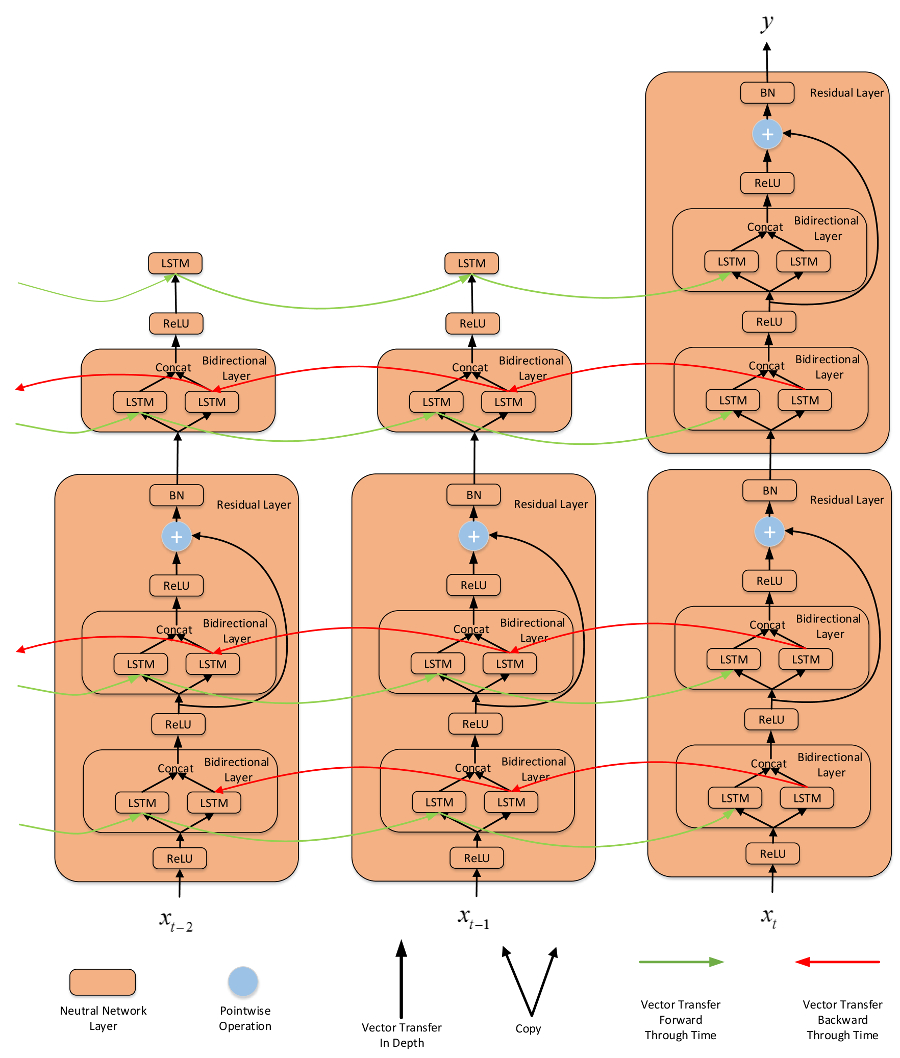

In [18]:
from IPython.core.display import Image, display
display(Image('material/re_bi_lstm.jpg', width=800, height=1200, unconfined=True))

2 residual cells as a block stacked 2 times for a total of 4 bidirectional cells, which is in reality 8 unidirectional LSTM cells. We obtain best results with a 3x3 architecture, consisting of 18 LSTM cells.